In [17]:
import pandas as pd
import numpy as np, pandas as pd
from scipy import stats
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import geopandas as gpd
from geopandas import GeoDataFrame
import warnings
import hashlib
import h3
from h3 import h3
import json
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import matplotlib.patheffects as path_effects
from shapely import wkt
import seaborn as sns


# Create Dataset with h3 indexes

In [22]:
def add_h3_indexes(df, lat_col, lon_col, resolutions, name):
    for resolution in resolutions:
        h3_col_name = f'h3_res_{resolution}_{name}'
        df[h3_col_name] = df.apply(lambda row: h3.geo_to_h3(row[lat_col], row[lon_col], resolution), axis=1)
                   


In [12]:
df = pd.read_csv("../Datasets/taxi_trips_with_weather_cleaned.csv")
df = df[['trip_id', 'taxi_id', 'timestamp_start', 'timestamp_end', 'duration','distance', 'fare', 
       'company', 'pickup_lat', 'pickup_long', 'pickup_location', 'dropoff_lat', 'dropoff_long', 'dropoff_location']]
df.head()

trip_id                           taxi_id  \
0  0cd46aa628ea5f871630113eb8ba92e4  09a6eaba341c43fc653756deff43a50f   
1  4fbe84436a116f11c51ef3306e7adf0c  0f66b306ebea0f05dd124bf958729b64   
2  08a197de2703972bad8877628b18bb30  5a3410255ea0041b967e74090838b14d   
3  94f8c8a4624a061988e0f32e12be04c5  3049f212da83687eb7ea5cb9d3046d89   
4  dd25d5229b1ce93ea03b7c9357e6f4f9  d9d9d16f34141de38105a060abd8a90c   

       timestamp_start        timestamp_end  duration  distance   fare  tips  \
0  2020-01-01 00:00:00  2020-01-01 00:15:00     180.0      0.64   4.50  0.00   
1  2020-01-01 00:00:00  2020-01-01 00:30:00    1723.0      1.13  12.00  0.00   
2  2020-01-01 00:00:00  2020-01-01 00:00:00     420.0      0.97   6.00  0.00   
3  2020-01-01 00:00:00  2020-01-01 00:30:00    1320.0      8.21  16.75  3.85   
4  2020-01-01 00:00:00  2020-01-01 00:15:00     504.0      1.19   6.25  0.00   

   tolls  extras  ...  dropoff_long                      dropoff_location  \
0    0.0     1.0  ...    -87.626211  POINT (-87.6262105324 41.8991556134)   
1    0.0     0.0  ...    -87.626215  POINT (-87.6262149064 41.8925077809)   
2    0.0     1.0  ...    -87.618868  POINT (-87.6188683546 41.8909220259)   
3    0.0     2.0  ...    -87.676356  POINT (-87.6763559892 41.9012069941)   
4    0.0     1.0  ...    -87.626215  POINT (-87.6262149064 41.8925077809)   

  temperature  dew_point  humidity wind_speed  wind_gust  pressure  \
0       -2.83      -5.33      83.0       0.48       0.64    1.0088   
1       -2.83      -5.33      83.0       0.48       0.64    1.0088   
2       -2.83      -5.33      83.0       0.48       0.64    1.0088   
3       -2.83      -5.33      83.0       0.48       0.64    1.0088   
4       -2.83      -5.33      83.0       0.48       0.64    1.0088   

  precipitation_rate  precipitation_accumulation  
0                0.0                         0.0  
1                0.0                         0.0  
2                0.0                         0.0  
3                0.0                         0.0  
4                0.0                         0.0  

[5 rows x 27 columns]

In [35]:
# Transforms the string into a shapely geometry object
df['pickup_location'] = df['pickup_location'].apply(wkt.loads)
df['dropoff_location'] = df['dropoff_location'].apply(wkt.loads)

gdf = gpd.GeoDataFrame(df, geometry='pickup_location', crs="EPSG:4326")
gdf.set_geometry('dropoff_location', inplace=True, crs="EPSG:4326")

In [47]:
add_h3_indexes(gdf, "pickup_lat", "pickup_long", [6,7,8,9], "start")
add_h3_indexes(gdf, "dropoff_lat", "dropoff_long", [6,7,8,9], "end")

# possibly also use a function to create the hexagons out of the h3 indexes

gdf

trip_id                           taxi_id  \
0        0cd46aa628ea5f871630113eb8ba92e4  09a6eaba341c43fc653756deff43a50f   
1        4fbe84436a116f11c51ef3306e7adf0c  0f66b306ebea0f05dd124bf958729b64   
2        08a197de2703972bad8877628b18bb30  5a3410255ea0041b967e74090838b14d   
3        94f8c8a4624a061988e0f32e12be04c5  3049f212da83687eb7ea5cb9d3046d89   
4        dd25d5229b1ce93ea03b7c9357e6f4f9  d9d9d16f34141de38105a060abd8a90c   
...                                   ...                               ...   
3130249  16d5c40e63e94e78beb1d9fbcfceef8a  c1230d31b8c9c8333639891b493cf984   
3130250  0cc1c1567bad3bd6fbbe3f23054c7803  7e1c99cf531fbf8e4937528c1c6e2f5e   
3130251  813b6f817578b816cf91d12eae5e2d22  8441466e1bfb7ee2d86c7d5ee8108dee   
3130252  6be2dbeac02d83e4f7599716403260b4  34184d459512d0cdefc62ea1a29acf83   
3130253  5d12ea68a4f3aa4b45ab234ccf558056  844e195218cc1a16a796943371dd9fce   

             timestamp_start        timestamp_end  duration  distance   fare  \
0        2020-01-01 00:00:00  2020-01-01 00:15:00     180.0      0.64   4.50   
1        2020-01-01 00:00:00  2020-01-01 00:30:00    1723.0      1.13  12.00   
2        2020-01-01 00:00:00  2020-01-01 00:00:00     420.0      0.97   6.00   
3        2020-01-01 00:00:00  2020-01-01 00:30:00    1320.0      8.21  16.75   
4        2020-01-01 00:00:00  2020-01-01 00:15:00     504.0      1.19   6.25   
...                      ...                  ...       ...       ...    ...   
3130249  2020-12-31 23:45:00  2020-12-31 23:45:00     278.0      2.30   6.50   
3130250  2020-12-31 23:45:00  2021-01-01 00:15:00    1320.0      1.13  33.00   
3130251  2020-12-31 23:45:00  2021-01-01 00:00:00     587.0      7.97  14.50   
3130252  2020-12-31 23:45:00  2021-01-01 00:00:00     565.0      3.22   8.75   
3130253  2020-12-31 23:45:00  2020-12-31 23:45:00     716.0     14.39  23.50   

                               company  pickup_lat  pickup_long  ...  \
0        Taxicab Insurance Agency, LLC   41.898332   -87.620763  ...   
1                 Chicago Independents   41.892042   -87.631864  ...   
2            Taxi Affiliation Services   41.895033   -87.619711  ...   
3            Taxi Affiliation Services   41.965812   -87.655879  ...   
4                            Flash Cab   41.898332   -87.620763  ...   
...                                ...         ...          ...  ...   
3130249                      Flash Cab   41.899602   -87.633308  ...   
3130250      Taxi Affiliation Services   41.792592   -87.769615  ...   
3130251                      Flash Cab   41.706126   -87.598256  ...   
3130252                   City Service   41.899602   -87.633308  ...   
3130253                      Flash Cab   41.899602   -87.633308  ...   

        dropoff_long            dropoff_location   h3_res_6_start  \
0         -87.626211  POINT (-87.62621 41.89916)  862664c1fffffff   
1         -87.626215  POINT (-87.62621 41.89251)  862664c1fffffff   
2         -87.618868  POINT (-87.61887 41.89092)  862664c1fffffff   
3         -87.676356  POINT (-87.67636 41.90121)  862664d8fffffff   
4         -87.626215  POINT (-87.62621 41.89251)  862664c1fffffff   
...              ...                         ...              ...   
3130249   -87.633308  POINT (-87.63331 41.89960)  862664c1fffffff   
3130250   -87.633308  POINT (-87.63331 41.89960)  862664527ffffff   
3130251   -87.635740  POINT (-87.63574 41.67382)  862664ccfffffff   
3130252   -87.676356  POINT (-87.67636 41.90121)  862664c1fffffff   
3130253   -87.723452  POINT (-87.72345 41.95358)  862664c1fffffff   

          h3_res_7_start   h3_res_8_start   h3_res_9_start     h3_res_6_end  \
0        872664c1effffff  882664c1e9fffff  892664c1e8fffff  862664c1fffffff   
1        872664c1effffff  882664c1e7fffff  892664c1e73ffff  862664c1fffffff   
2        872664c1effffff  882664c1ebfffff  892664c1eabffff  862664c1fffffff   
3        872664d89ffffff  882664d897fffff  892664d8973ffff  862664cafffffff   
4        872664c1effffff  882664c1e

In [56]:
gdf.to_pickle("../Datasets/taxi_trips_with_h3_indexes.pkl")

# Spatial Analytics

In [19]:
gdf = pd.read_pickle('../Datasets/taxi_trips_with_h3_indexes.pkl')

In [20]:
gdf.head()

trip_id                           taxi_id  \
0  0cd46aa628ea5f871630113eb8ba92e4  09a6eaba341c43fc653756deff43a50f   
1  4fbe84436a116f11c51ef3306e7adf0c  0f66b306ebea0f05dd124bf958729b64   
2  08a197de2703972bad8877628b18bb30  5a3410255ea0041b967e74090838b14d   
3  94f8c8a4624a061988e0f32e12be04c5  3049f212da83687eb7ea5cb9d3046d89   
4  dd25d5229b1ce93ea03b7c9357e6f4f9  d9d9d16f34141de38105a060abd8a90c   

       timestamp_start        timestamp_end  duration  distance   fare  \
0  2020-01-01 00:00:00  2020-01-01 00:15:00     180.0      0.64   4.50   
1  2020-01-01 00:00:00  2020-01-01 00:30:00    1723.0      1.13  12.00   
2  2020-01-01 00:00:00  2020-01-01 00:00:00     420.0      0.97   6.00   
3  2020-01-01 00:00:00  2020-01-01 00:30:00    1320.0      8.21  16.75   
4  2020-01-01 00:00:00  2020-01-01 00:15:00     504.0      1.19   6.25   

                         company  pickup_lat  pickup_long  ... dropoff_long  \
0  Taxicab Insurance Agency, LLC   41.898332   -87.620763  ...   -87.626211   
1           Chicago Independents   41.892042   -87.631864  ...   -87.626215   
2      Taxi Affiliation Services   41.895033   -87.619711  ...   -87.618868   
3      Taxi Affiliation Services   41.965812   -87.655879  ...   -87.676356   
4                      Flash Cab   41.898332   -87.620763  ...   -87.626215   

             dropoff_location   h3_res_6_start   h3_res_7_start  \
0  POINT (-87.62621 41.89916)  862664c1fffffff  872664c1effffff   
1  POINT (-87.62621 41.89251)  862664c1fffffff  872664c1effffff   
2  POINT (-87.61887 41.89092)  862664c1fffffff  872664c1effffff   
3  POINT (-87.67636 41.90121)  862664d8fffffff  872664d89ffffff   
4  POINT (-87.62621 41.89251)  862664c1fffffff  872664c1effffff   

    h3_res_8_start   h3_res_9_start     h3_res_6_end     h3_res_7_end  \
0  882664c1e9fffff  892664c1e8fffff  862664c1fffffff  872664c1effffff   
1  882664c1e7fffff  892664c1e73ffff  862664c1fffffff  872664c1effffff   
2  882664c1ebfffff  892664c1eabffff  862664c1fffffff  872664c1effffff   
3  882664d897fffff  892664d8973ffff  862664cafffffff  872664cacffffff   
4  882664c1e9fffff  892664c1e8fffff  862664c1fffffff  872664c1effffff   

      h3_res_8_end     h3_res_9_end  
0  882664c1e1fffff  892664c1e13ffff  
1  882664c1e1fffff  892664c1e0fffff  
2  882664c1e3fffff  892664c1e33ffff  
3  882664cac3fffff  892664cac3bffff  
4  882664c1e1fffff  892664c1e0fffff  

[5 rows x 22 columns]

In [21]:
print(len(gdf['h3_res_6_start'].unique()))
print(len(gdf['h3_res_7_start'].unique()))
print(len(gdf['h3_res_8_start'].unique()))
print(len(gdf['h3_res_9_start'].unique()))

27
113
333
453


Due to the latitude and longitude being the centroid lat/long of the respective pickup census tract or the community area, the further discretization from resolution 8 to 9 leads to just a marginal increase of hexagons.

In [23]:
# Read the GeoJSON file of the Chicago Community Areas
geojson_file = "../Datasets/Boundaries - Community Areas.geojson"
community_area_boundaries = gpd.read_file(geojson_file)

# Combine all the community areas into one shape (union of all geometries)
chicago_shape = unary_union(community_area_boundaries['geometry'])

## Density Heatmap of Trip Pickup and Dropoff Locations

C:\Users\ducan\AppData\Local\Temp\ipykernel_27800\1391972779.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trips_geo['centroid'] = trips_geo.geometry.centroid
C:\Users\ducan\AppData\Local\Temp\ipykernel_27800\1391972779.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.array(list(zip(trips_geo.centroid.x, trips_geo.centroid.y)))
C:\Users\ducan\AppData\Local\Temp\ipykernel_27800\1391972779.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trips_geo['centroid'] = trips_geo.geometry.centroid
C:\Users\ducan\AppData\Local\Temp\ipykernel_27800\13919

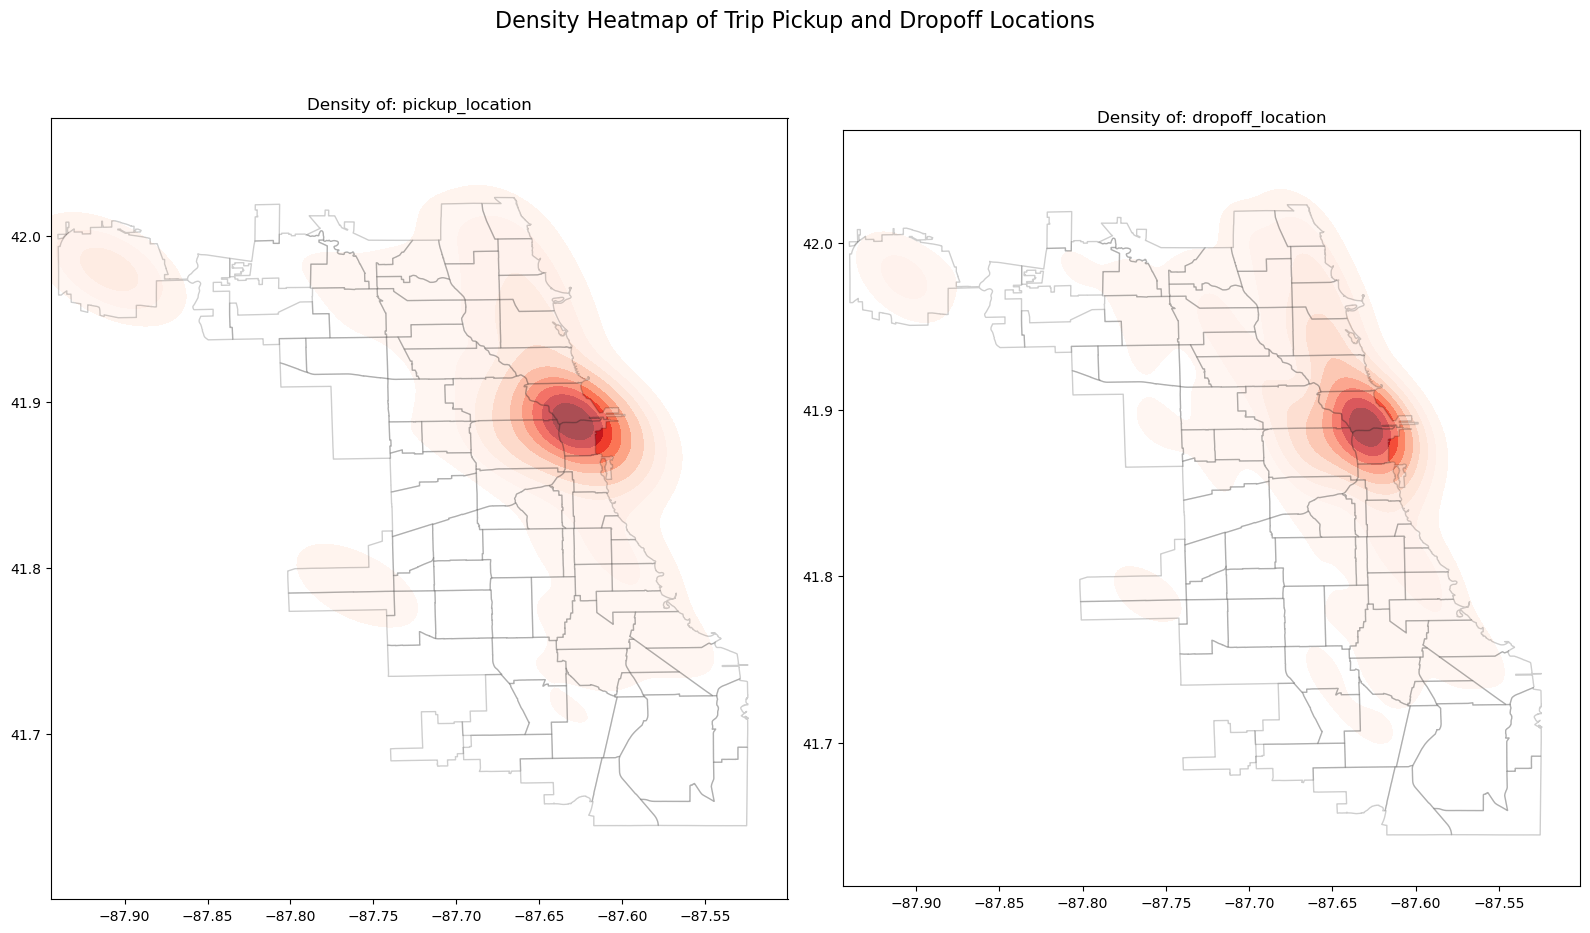

In [25]:
fig, ax = plt.subplots(1,2, figsize=(16,10))

def plot_chicago_shape(ax):
    community_area_boundaries.plot(ax=ax, color='white', alpha=0.2, edgecolor='k')
    gpd.GeoSeries([chicago_shape]).plot(ax=ax, color='white', alpha=0.1)

def density_heatmap(gdf, location_pov, ax_index):
    trips = gdf[[location_pov]].groupby(location_pov).size().reset_index()
    trips.columns = ['geometry', 'count']
    trips_geo = gpd.GeoDataFrame(trips, geometry = trips['geometry'])
    
    trips_geo['centroid'] = trips_geo.geometry.centroid
    centroids = np.array(list(zip(trips_geo.centroid.x, trips_geo.centroid.y)))
    weights = trips_geo['count'].values # grouping and aggregating on size results in the frequency in column 0
    sns.kdeplot(ax = ax[ax_index], x=centroids[:,0], y=centroids[:,1], weights=weights, cmap="Reds", fill=True, bw_adjust=0.5)
    plot_chicago_shape(ax[ax_index])
    ax[ax_index].set_title(f'Density of: {location_pov}')

density_heatmap(gdf, 'pickup_location', 0)
density_heatmap(gdf, 'dropoff_location', 1)

fig.suptitle('Density Heatmap of Trip Pickup and Dropoff Locations', fontsize=16)
plt.tight_layout()
plt.show()

On average pickup and dropoff density appears to be similar, with relatively more pickups happening in the community area north west. There is one area with extremely high density of trips starting and ending. 

### TODO- Check POIs to give explanation for this pattern

## Chloropleth Map of Average Trip Price and Length and Duration

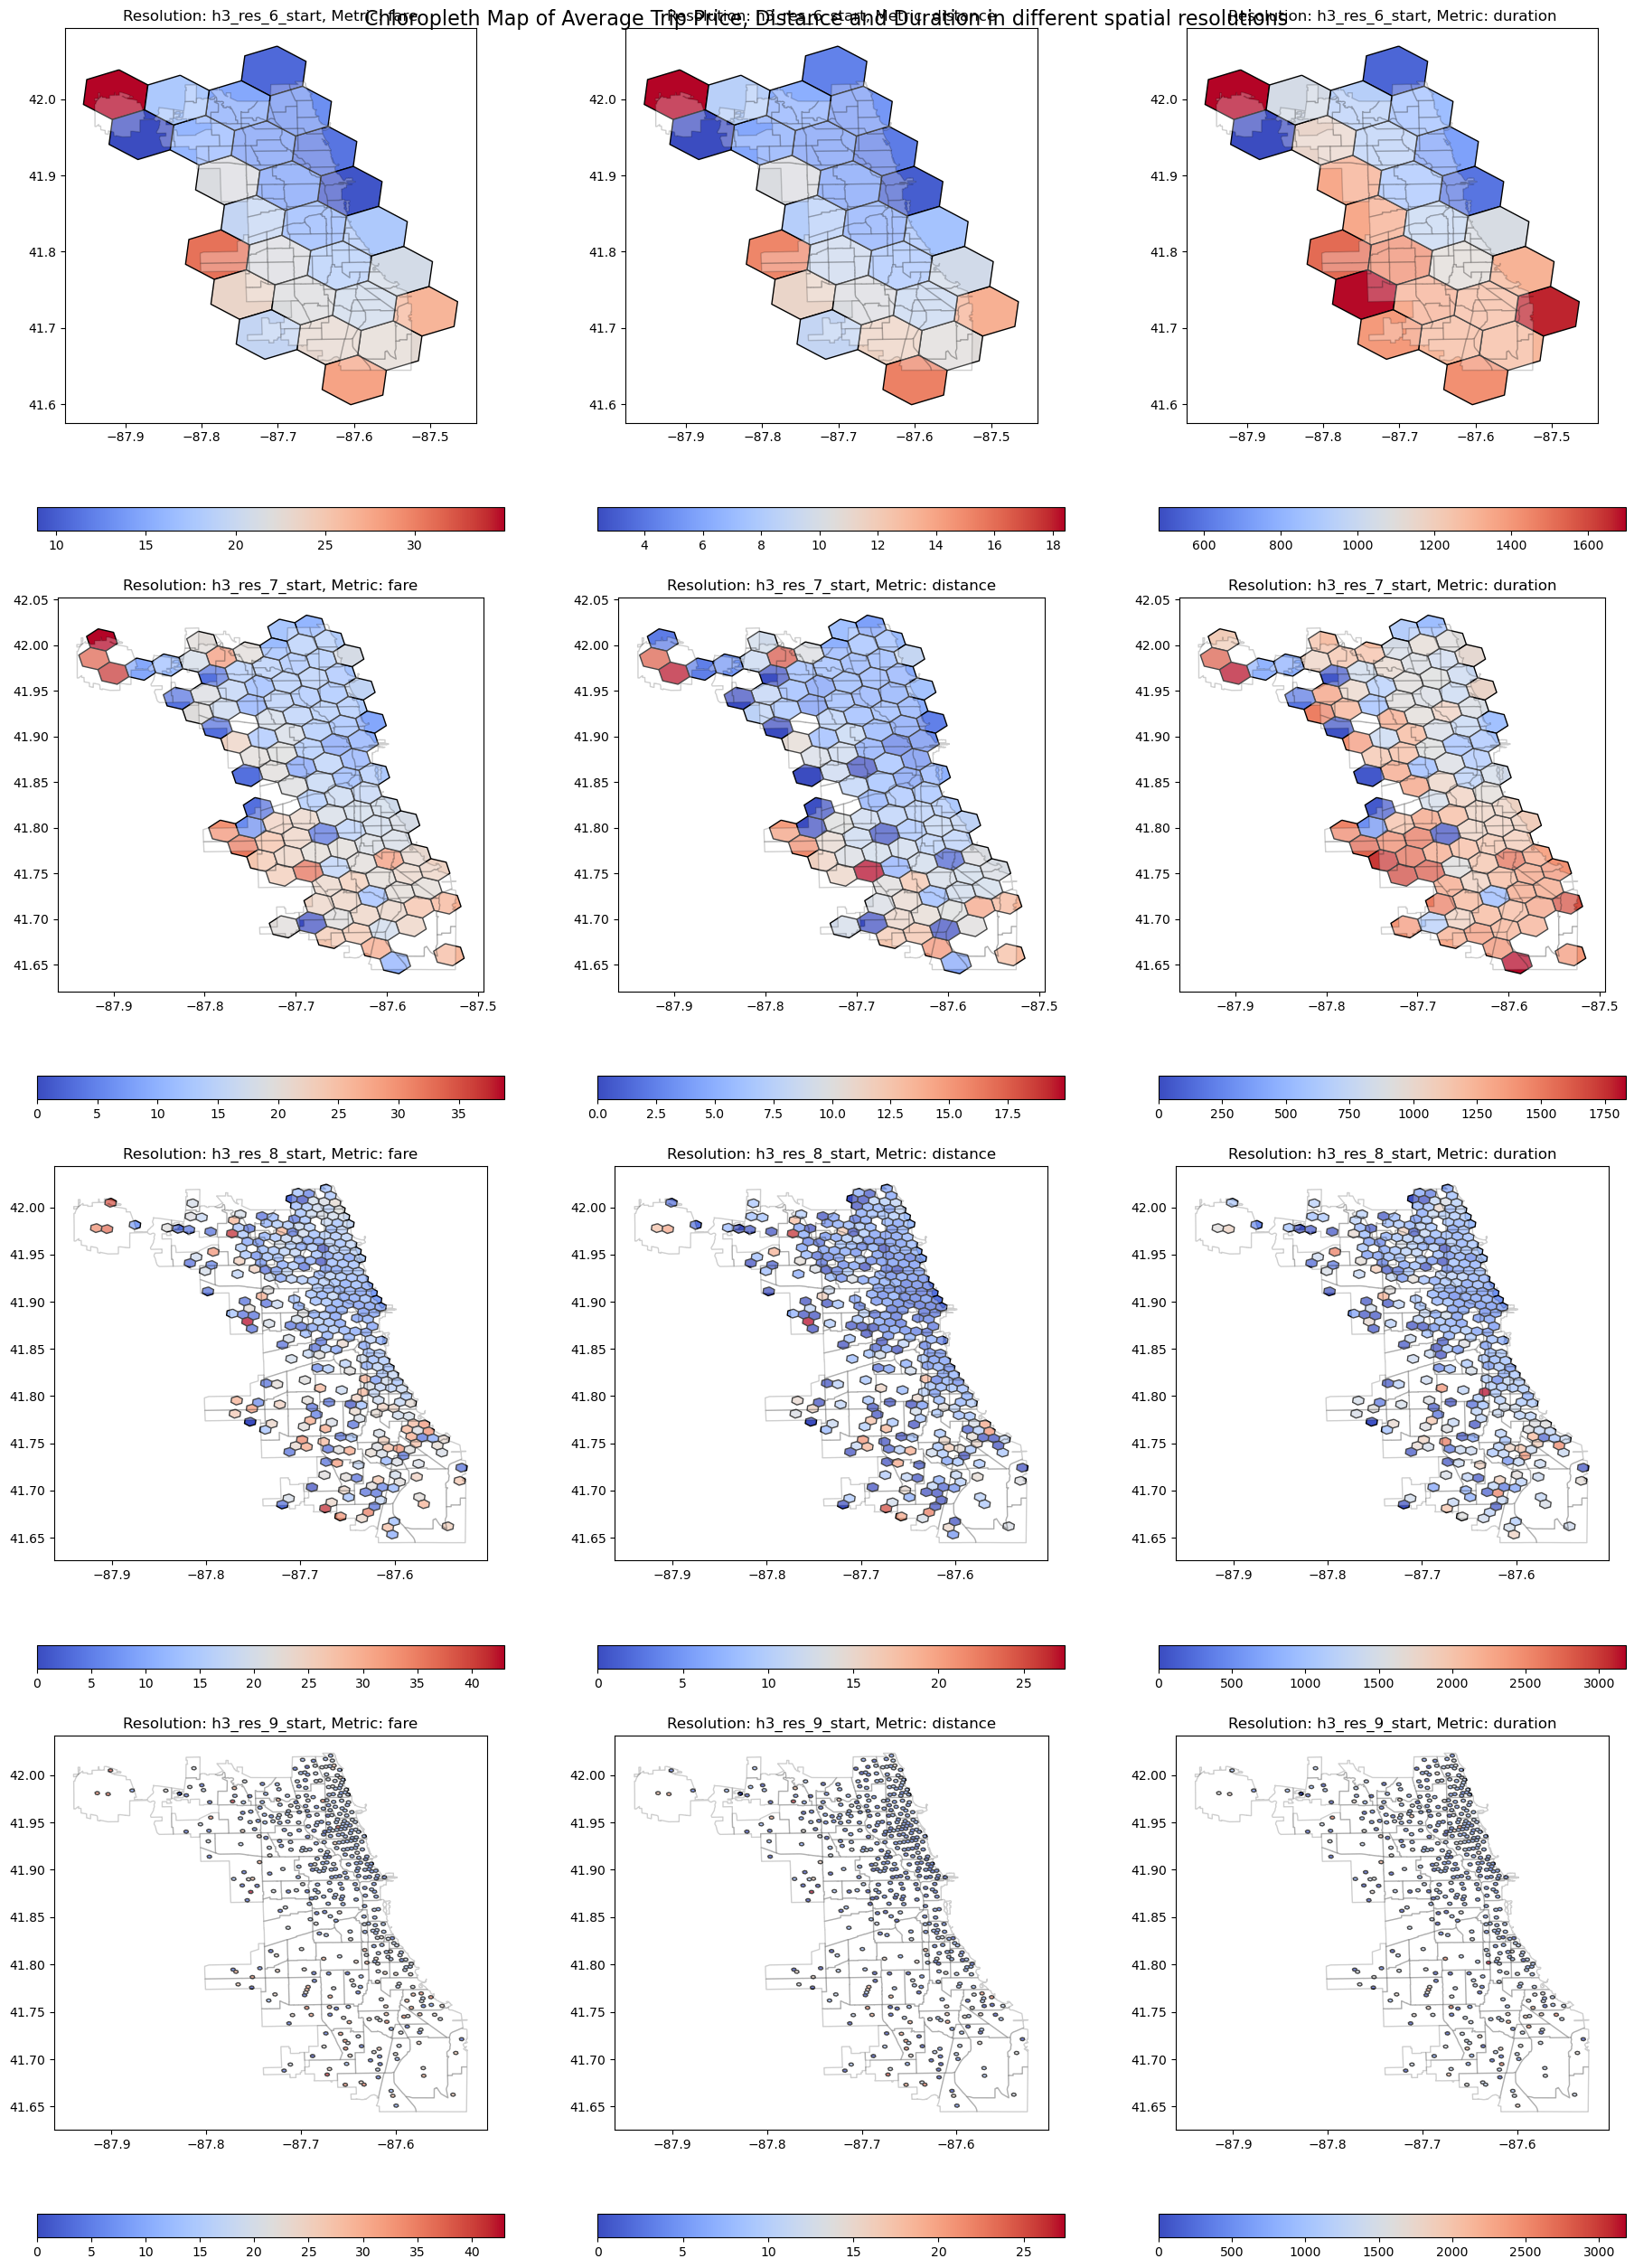

In [121]:
resolutions = ['h3_res_6_start', 'h3_res_7_start', 'h3_res_8_start', 'h3_res_9_start']
metrics = ['fare', 'distance', 'duration']

nrows = len(resolutions)
ncols = len(metrics)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6,nrows * 6+2))
axes = axes.flatten()

def chloropleth_means_map(gdf, resolution, metric):

    chloro_mean = pd.DataFrame()
    chloro_mean = gdf[[resolution, metric]].groupby(resolution).mean().reset_index()
    chloro_mean.columns = ['id', 'mean']
    chloro_mean['geometry'] = chloro_mean.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["id"], geo_json=True)), axis=1)

    chloro_mean_geo = gpd.GeoDataFrame(chloro_mean, geometry=chloro_mean['geometry'], crs='EPSG:4326')
    return chloro_mean_geo

ax_index = 0
for resolution in resolutions:
    for metric in metrics:
        ax = axes[ax_index]
        chloropleth_means_map(gdf, resolution, metric).plot(ax = ax, column='mean', cmap='coolwarm', edgecolor='k', legend = True, legend_kwds = {'orientation': 'horizontal'})
        plot_chicago_shape(ax)
        ax.set_title(f'Resolution: {resolution}, Metric: {metric}')
        ax_index +=1
        
fig.suptitle('Chloropleth Map of Average Trip Price, Distance and Duration in different spatial resolutions', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.01, wspace=0.2) 
plt.show()



Fare and distance means across spatial dimensions seem to be proportionally similar, while duration shows different distribution of means. Trips that start in the southern area tend to take longer. This is due to the fare being calculated mostly based on additional mile (2.25 dollars per mile), while elapsed time is priced only at 0.20 dollars per 36 seconds.

Source: https://www.chicago.gov/content/dam/city/depts/bacp/publicvehicleinfo/Chicabs/chicagotaxiplacard20200629.pdf

# Temporal Analytics

In [32]:
def generate_time_series(start_time, end_time, freq_minutes):
    """
    Generate a time series with additional features.
    
    Parameters:
    start_time (str): The start time in 'YYYY-MM-DD HH:MM:SS' format.
    end_time (str): The end time in 'YYYY-MM-DD HH:MM:SS' format.
    freq_minutes (int): Frequency of the time series in minutes.
    
    Returns:
    DataFrame: A DataFrame containing the time series and additional features.
    """
    # Create the time series
    time_series = pd.date_range(start=start_time, end=end_time, freq=f'{freq_minutes}T')
    df = pd.DataFrame(time_series, columns=['datetime'])
    
    # Extract additional features
    df['weekday'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week
    df['quarter'] = df['datetime'].dt.quarter
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    df['hour'] = df['datetime'].dt.hour
    df['is_month_start'] = df['datetime'].dt.is_month_start
    df['is_month_end'] = df['datetime'].dt.is_month_end
    df['is_quarter_start'] = df['datetime'].dt.is_quarter_start
    df['is_quarter_end'] = df['datetime'].dt.is_quarter_end
    df['is_year_start'] = df['datetime'].dt.is_year_start
    df['is_year_end'] = df['datetime'].dt.is_year_end
    df['is_leap_year'] = df['datetime'].dt.is_leap_year
    
    # Define time of day segments
    def get_time_of_day(hour):
        if hour >= 5 and hour < 12:
            return 'morning'
        elif hour >= 12 and hour < 17:
            return 'afternoon'
        elif hour >= 17 and hour < 21:
            return 'evening'
        else:
            return 'night'
        
    # Define 4h segments
    def get_4h_bucket(hour):
        if hour >= 0 and hour < 4:
            return '0-4'
        elif hour >= 4 and hour < 8:
            return '4-8'
        elif hour >= 8 and hour < 12:
            return '8-12'
        elif hour >= 12 and hour < 16:
            return '12-16'
        elif hour >= 16 and hour < 20:
            return '16-20'
        else:
            return '20-24'
    
    df['time_of_day'] = df['hour'].apply(get_time_of_day)
    df['4h_bucket'] = df['hour'].apply(get_4h_bucket)
    
    
    return df

# Example usage
start_time = '2020-01-01 00:00:00'
end_time = '2021-01-01 00:00:00'
freq_minutes = 15

time_series_df = generate_time_series(start_time, end_time, freq_minutes)
time_series_df.head()

datetime  weekday  month  day_of_year  week_of_year  quarter  \
0 2020-01-01 00:00:00        2      1            1             1        1   
1 2020-01-01 00:15:00        2      1            1             1        1   
2 2020-01-01 00:30:00        2      1            1             1        1   
3 2020-01-01 00:45:00        2      1            1             1        1   
4 2020-01-01 01:00:00        2      1            1             1        1   

   is_weekend  hour  is_month_start  is_month_end  is_quarter_start  \
0           0     0            True         False              True   
1           0     0            True         False              True   
2           0     0            True         False              True   
3           0     0            True         False              True   
4           0     1            True         False              True   

   is_quarter_end  is_year_start  is_year_end  is_leap_year time_of_day  \
0           False           True        False          True       night   
1           False           True        False          True       night   
2           False           True        False          True       night   
3           False           True        False          True       night   
4           False           True        False          True       night   

  4h_bucket  
0       0-4  
1       0-4  
2       0-4  
3       0-4  
4       0-4

In [33]:
gdf['timestamp_start'] = pd.to_datetime(gdf['timestamp_start'])
gdf['timestamp_end'] = pd.to_datetime(gdf['timestamp_end'])
gdf_ts = gdf.merge(time_series_df, left_on='timestamp_start', right_on='datetime', how = 'left')
gdf_ts.head()

trip_id                           taxi_id  \
0  0cd46aa628ea5f871630113eb8ba92e4  09a6eaba341c43fc653756deff43a50f   
1  4fbe84436a116f11c51ef3306e7adf0c  0f66b306ebea0f05dd124bf958729b64   
2  08a197de2703972bad8877628b18bb30  5a3410255ea0041b967e74090838b14d   
3  94f8c8a4624a061988e0f32e12be04c5  3049f212da83687eb7ea5cb9d3046d89   
4  dd25d5229b1ce93ea03b7c9357e6f4f9  d9d9d16f34141de38105a060abd8a90c   

  timestamp_start       timestamp_end  duration  distance   fare  \
0      2020-01-01 2020-01-01 00:15:00     180.0      0.64   4.50   
1      2020-01-01 2020-01-01 00:30:00    1723.0      1.13  12.00   
2      2020-01-01 2020-01-01 00:00:00     420.0      0.97   6.00   
3      2020-01-01 2020-01-01 00:30:00    1320.0      8.21  16.75   
4      2020-01-01 2020-01-01 00:15:00     504.0      1.19   6.25   

                         company  pickup_lat  pickup_long  ... hour  \
0  Taxicab Insurance Agency, LLC   41.898332   -87.620763  ...    0   
1           Chicago Independents   41.892042   -87.631864  ...    0   
2      Taxi Affiliation Services   41.895033   -87.619711  ...    0   
3      Taxi Affiliation Services   41.965812   -87.655879  ...    0   
4                      Flash Cab   41.898332   -87.620763  ...    0   

   is_month_start  is_month_end is_quarter_start is_quarter_end is_year_start  \
0            True         False             True          False          True   
1            True         False             True          False          True   
2            True         False             True          False          True   
3            True         False             True          False          True   
4            True         False             True          False          True   

  is_year_end is_leap_year time_of_day 4h_bucket  
0       False         True       night       0-4  
1       False         True       night       0-4  
2       False         True       night       0-4  
3       False         True       night       0-4  
4       False         True       night       0-4  

[5 rows x 39 columns]

## Number of Taxi Trips across the Day

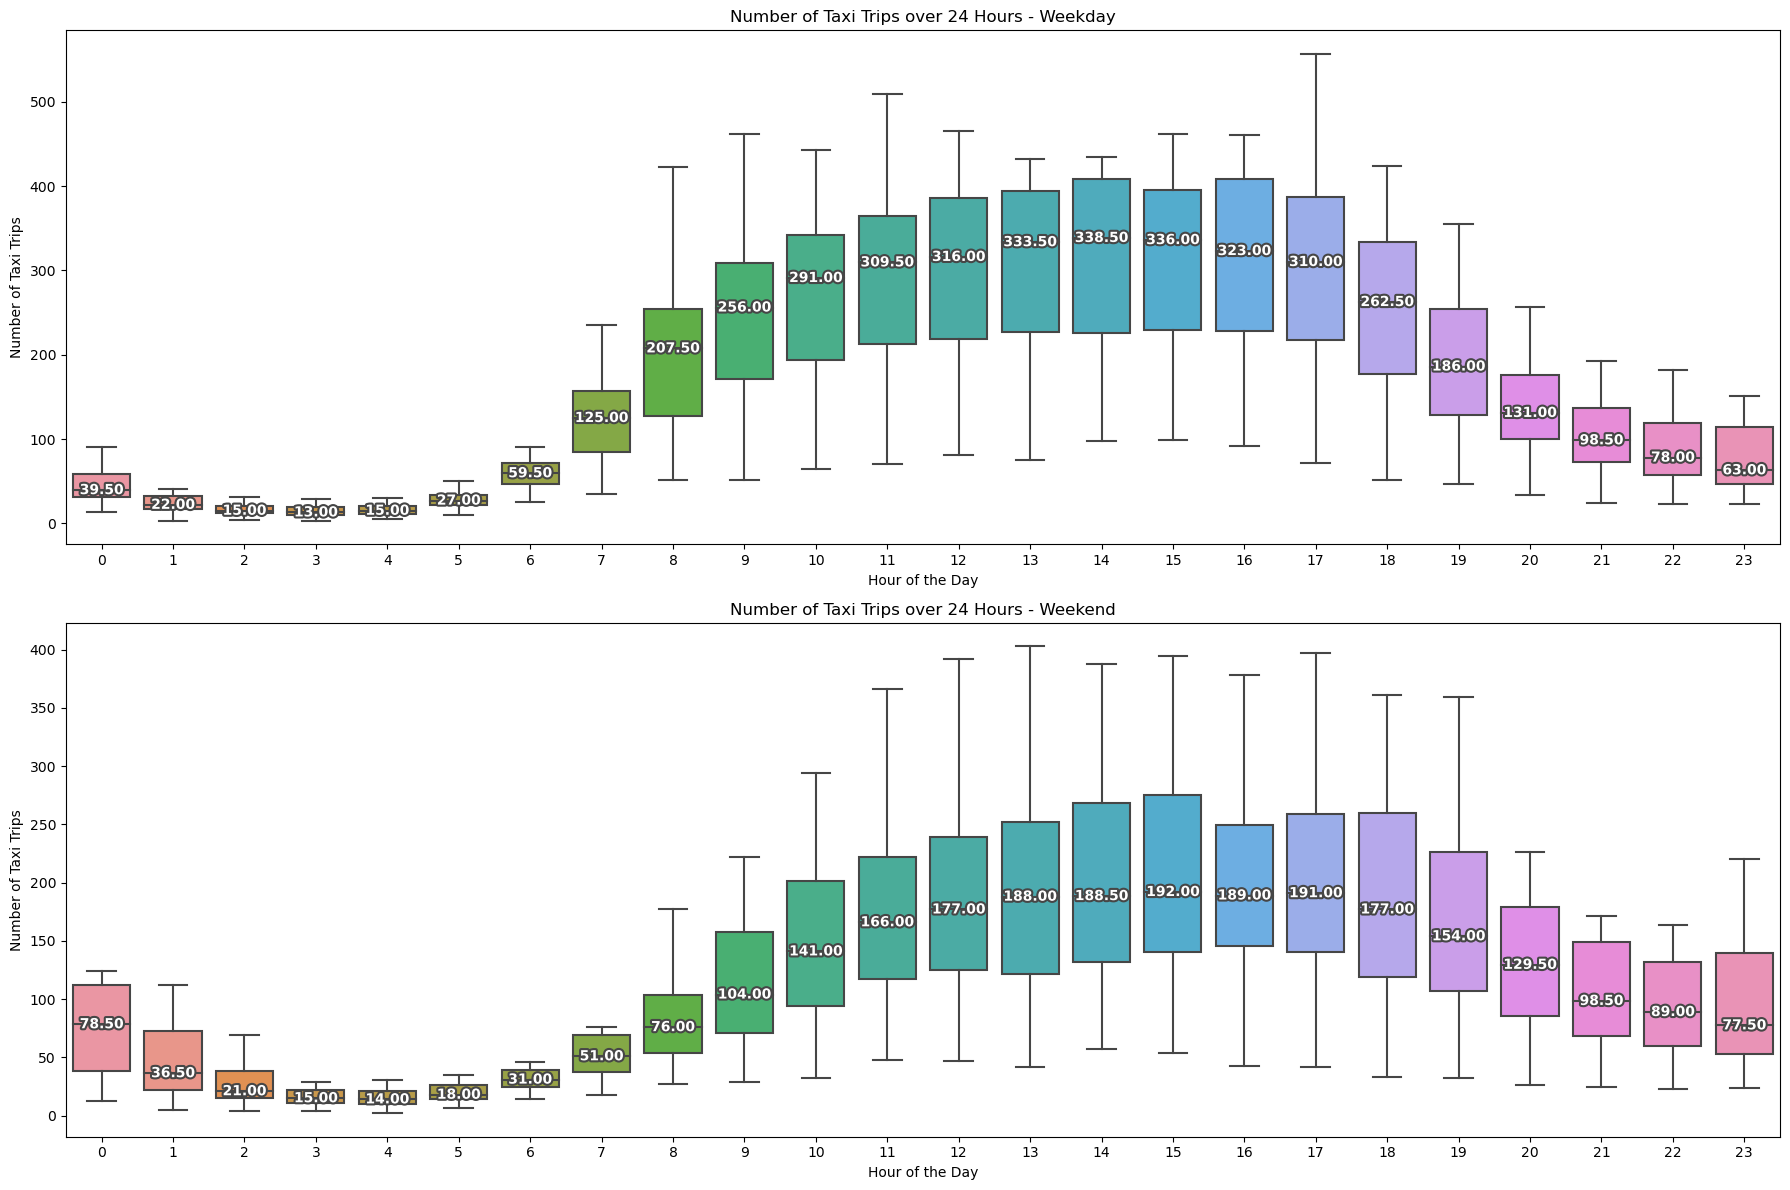

In [77]:
def add_median_labels(ax: matplotlib.axes.Axes, fmt='.2f'):
    """Add labels for the median at its location.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        fmt (String): The rounding format.
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

def boxplot_across_day(data, ylabel, title, ax_index):
    
    ax = axes[ax_index]
    a = sns.boxplot(x='hour', y='value', data=data, ax = ax, showfliers = False)
    add_median_labels(a)
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Hour of the Day')


trips_per_hour_weekday = gdf_ts[gdf_ts['is_weekend'] == 0][['day_of_year', 'hour']].groupby(by = ['day_of_year', 'hour']).size().reset_index()
trips_per_hour_weekday.columns = ['day_of_year', 'hour', 'value']

trips_per_hour_weekend = gdf_ts[gdf_ts['is_weekend'] == 1][['day_of_year', 'hour']].groupby(by = ['day_of_year', 'hour']).size().reset_index()
trips_per_hour_weekend.columns = ['day_of_year', 'hour', 'value']


fig, axes = plt.subplots(2, 1, figsize=(18, 12))
axes = axes.flatten()

boxplot_across_day(trips_per_hour_weekday, 'Number of Taxi Trips', 'Number of Taxi Trips over 24 Hours - Weekday', 0)
boxplot_across_day(trips_per_hour_weekend, 'Number of Taxi Trips', 'Number of Taxi Trips over 24 Hours - Weekend', 1)
plt.tight_layout()

Interestingly, weekends have much less taxi trips than weekdays. This pattern might be explained due to usage of taxis for work commuting or during weekdays having more urgent appointments. Weekends people have more time and energy to result to other transportation methods. At night, weekends have more trips proportionally but not as much as one would think - for 10 and 11 pm it is roughly 10-15 taxi rides more on average for the whole of chicago, while at 0 it is double so roughly 40 more. Possibly due to Covid leading to lockdown, there have not been that many events and bars open at night that would lead to more taxi traffic. 

## Mean Trip Duration per Kilometer across the Day

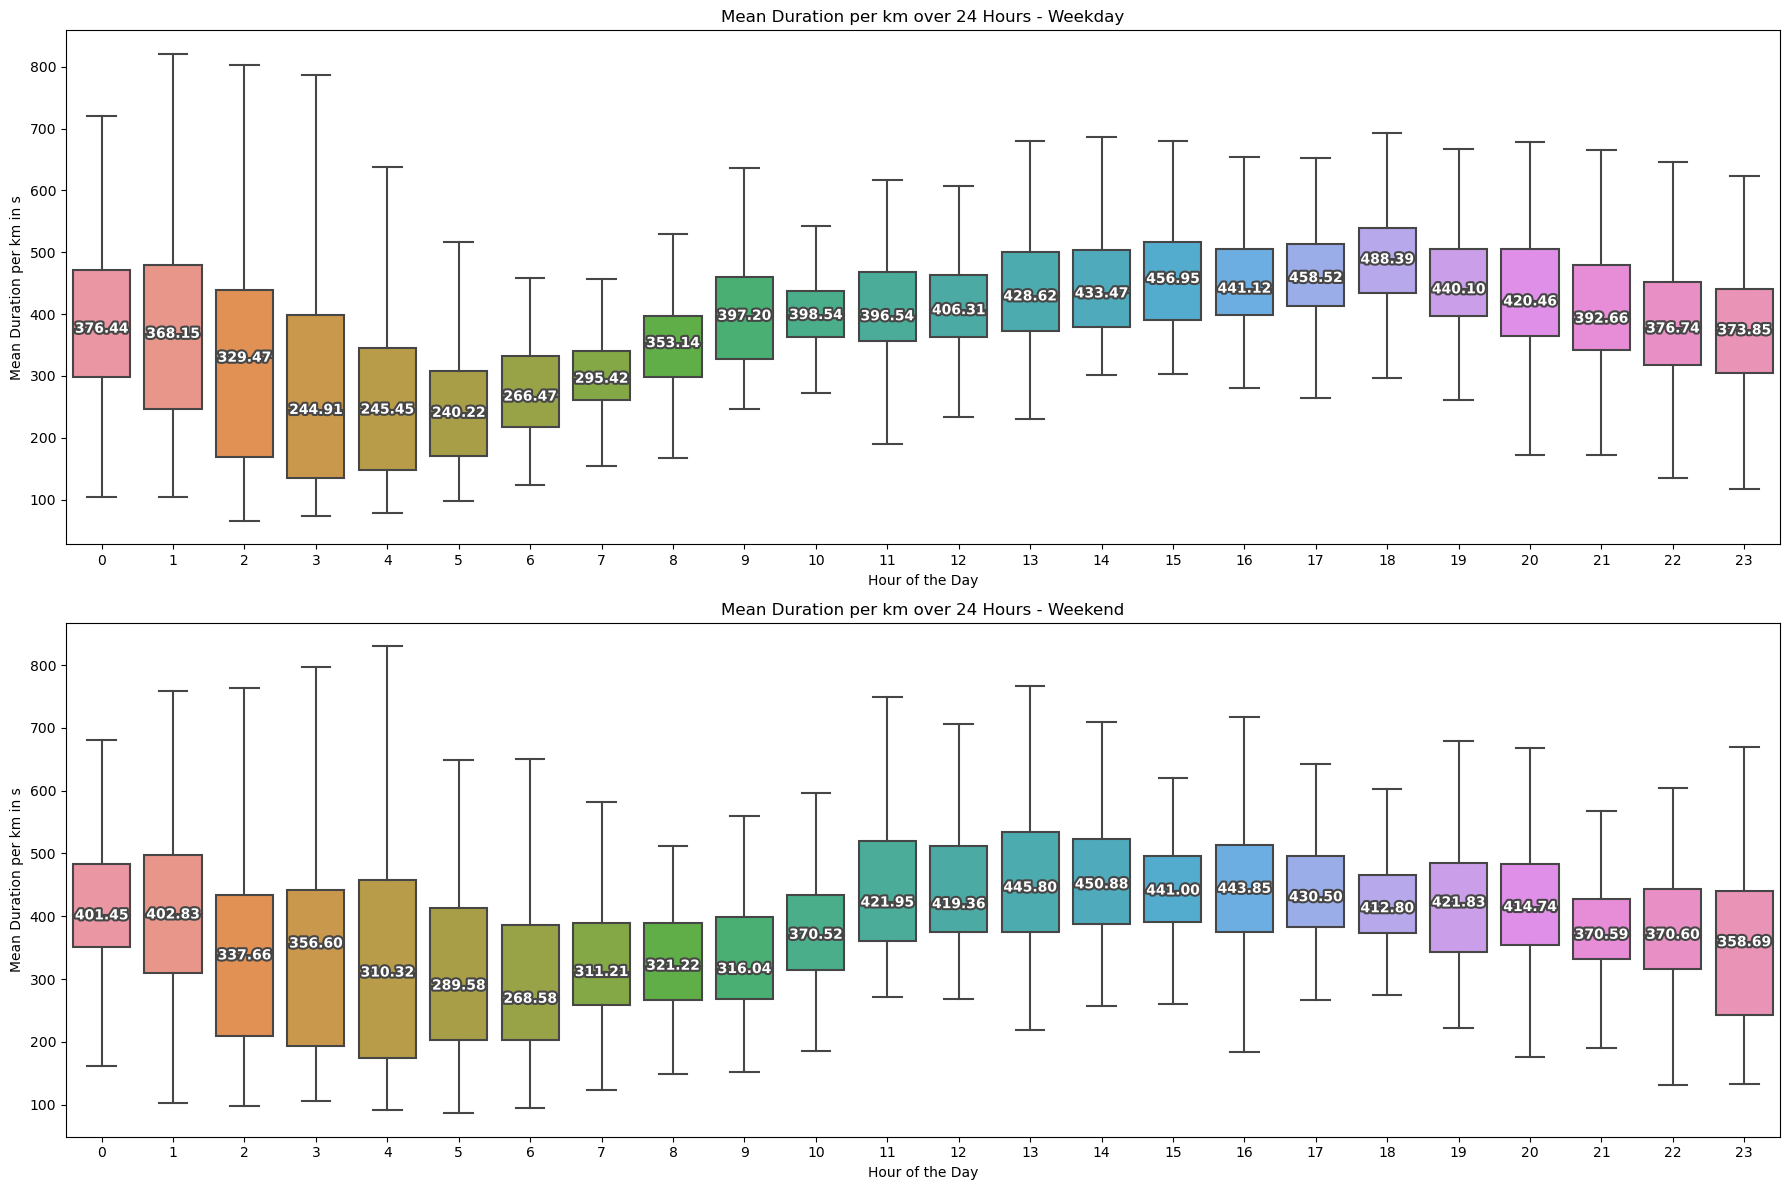

In [79]:
trip_length_per_hour_weekday = gdf_ts[(gdf_ts['is_weekend'] == 0) & (gdf_ts['distance'] != 0) & gdf_ts['duration'] != 0][['day_of_year', 'hour', 'distance', 'duration']]
trip_length_per_hour_weekday['duration_per_km'] = trip_length_per_hour_weekday['duration'] / trip_length_per_hour_weekday['distance']
trip_length_per_hour_weekday= trip_length_per_hour_weekday[['day_of_year', 'hour', 'duration_per_km']].groupby(by = ['day_of_year', 'hour']).mean().reset_index()
trip_length_per_hour_weekday.columns = ['day_of_year', 'hour', 'value']

trip_length_per_hour_weekend = gdf_ts[(gdf_ts['is_weekend'] == 1) & (gdf_ts['distance'] != 0) & gdf_ts['duration'] != 0][['day_of_year', 'hour', 'distance', 'duration']]
trip_length_per_hour_weekend['duration_per_km'] = trip_length_per_hour_weekend['duration'] / trip_length_per_hour_weekend['distance']
trip_length_per_hour_weekend= trip_length_per_hour_weekend[['day_of_year', 'hour', 'duration_per_km']].groupby(by = ['day_of_year', 'hour']).mean().reset_index()
trip_length_per_hour_weekend.columns = ['day_of_year', 'hour', 'value']

fig, axes = plt.subplots(2, 1, figsize=(18, 12))
axes = axes.flatten()

boxplot_across_day(trip_length_per_hour_weekday, 'Mean Duration per km in s', 'Mean Duration per km over 24 Hours - Weekday', 0)
boxplot_across_day(trip_length_per_hour_weekend, 'Mean Duration per km in s', 'Mean Duration per km over 24 Hours - Weekend', 1)
plt.tight_layout()

On weekdays we can see that the peak is around 6pm, which is usually the rush hour of commuting. Therefore, the time per km is the highest at that time. For weekends, from 11-20 the time per km stays the same indicating typical shopping hours and the most active time of the weekend.

## Idle Time of Taxis across the Day

In [41]:
gdf_idle = gdf_ts[gdf_ts.duplicated(subset=['taxi_id'], keep = False)]
gdf_idle = gdf_idle.sort_values(by=['taxi_id', 'timestamp_start', 'timestamp_end'])
gdf_idle['next_start_time'] = gdf_idle.groupby('taxi_id')['timestamp_start'].shift(-1)
gdf_idle['idle_time'] = (gdf_idle['next_start_time'] - gdf_idle['timestamp_end']).dt.total_seconds() / 60.0  # Idle time in minutes

# Handle cases where there is no next ride
gdf_idle['idle_time'] = gdf_idle['idle_time'].fillna(0)
gdf_idle

trip_id                           taxi_id  \
51765    bd5d926d7c6b6d0a67811784b44184e8  0006cebe7da8b1d1bba5d1e1ecae8181   
59393    2782ecae58768cfd233887aef7a145f8  0006cebe7da8b1d1bba5d1e1ecae8181   
64251    fed0bc7db12802d64f6fb292eb39b635  0006cebe7da8b1d1bba5d1e1ecae8181   
70094    d79755e24df821b393945e33be7acafb  0006cebe7da8b1d1bba5d1e1ecae8181   
77470    b6c1fbb8acdd5bf051a6ca27ccd31f97  0006cebe7da8b1d1bba5d1e1ecae8181   
...                                   ...                               ...   
2092920  ae94d49b177ab8accf44cf941e24b6d0  ffff0c3db2a7ba86bdb418a267551dff   
2129574  0fb2f63924db1d990116f29027717423  ffff0c3db2a7ba86bdb418a267551dff   
2129737  433f1a3a0ea24315b8aa3462ec3a52a9  ffff0c3db2a7ba86bdb418a267551dff   
2129893  a9a95029e32f4538253948043593428f  ffff0c3db2a7ba86bdb418a267551dff   
2154814  2f64c78bf8c5953bf5d320ecab2ba2e4  ffff0c3db2a7ba86bdb418a267551dff   

            timestamp_start       timestamp_end  duration  distance   fare  \
51765   2020-01-03 15:30:00 2020-01-03 16:15:00    2333.0     24.19  39.75   
59393   2020-01-03 19:15:00 2020-01-03 19:45:00    1617.0     23.79  37.50   
64251   2020-01-03 23:30:00 2020-01-04 00:15:00    2617.0     29.35  47.50   
70094   2020-01-04 12:45:00 2020-01-04 13:15:00    1959.0     25.20  40.25   
77470   2020-01-04 19:30:00 2020-01-04 20:00:00    1327.0     22.05  34.75   
...                     ...                 ...       ...       ...    ...   
2092920 2020-03-10 19:30:00 2020-03-10 19:45:00    1314.0      8.00  16.25   
2129574 2020-03-11 23:15:00 2020-03-11 23:30:00    1335.0     28.03  42.50   
2129737 2020-03-11 23:30:00 2020-03-11 23:45:00     429.0      2.78   7.50   
2129893 2020-03-11 23:45:00 2020-03-12 00:00:00    1009.0      8.35  16.50   
2154814 2020-03-12 20:15:00 2020-03-12 20:30:00    1550.0     28.10  43.00   

                           company  pickup_lat  pickup_long  ... is_month_end  \
51765    Chicago Carriage Cab Corp   41.979071   -87.903040  ...        False   
59393    Chicago Carriage Cab Corp   41.980264   -87.913625  ...        False   
64251    Chicago Carriage Cab Corp   41.980264   -87.913625  ...        False   
70094    Chicago Carriage Cab Corp   41.980264   -87.913625  ...        False   
77470    Chicago Carriage Cab Corp   41.980264   -87.913625  ...        False   
...                            ...         ...          ...  ...          ...   
2092920                  Flash Cab   41.878866   -87.625192  ...        False   
2129574                  Flash Cab   41.979071   -87.903040  ...        False   
2129737                  Flash Cab   41.899602   -87.633308  ...        False   
2129893                  Flash Cab   41.922686   -87.649489  ...        False   
2154814                  Flash Cab   41.979071   -87.903040  ...        False   

         is_quarter_start  is_quarter_end is_year_start is_year_end  \
51765               False           False         False       False   
59393               False           False         False       False   
64251               False           False         False       False   
70094               False           False         False       False   
77470               False           False         False       False   
...                   ...             ...           ...         ...   
2092920             False           False         False       False   
2129574             False           False         False       False   
2129737             False           False         False       False   
2129893             False           False         False       False   
2154814             False           False         False       False   

        is_leap_year time_of_day 4h_bucket     next_start_time idle_time  
51765           True   afternoon     12-16 2020-01-03 19:15:00     180.0  
59393           True     evening     16-20 2020-01-03 23:30:00     225.0  
64251           True       night     20-24 2020-01-04 12:45:00     750.0  
70094           True  

We need to remove or handle values that seem very high and likely result from breaks or shift changes. This helps to ensure the idle time data is representative of typical working conditions for the taxis and not skewed by non-working periods.

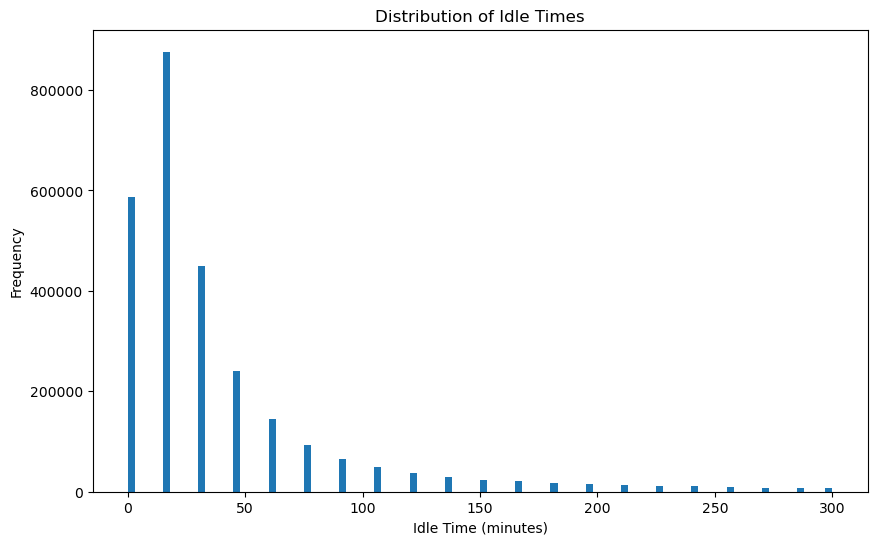

In [43]:
# Plot distribution of idle times
plt.figure(figsize=(10, 6))
gdf_idle['idle_time'].plot(kind='hist', bins=100, range=(0, 300))
plt.title('Distribution of Idle Times')
plt.xlabel('Idle Time (minutes)')
plt.ylabel('Frequency')
plt.show()

At more than 75 minutes of idle time the frequency barely changes, indicating that most of these are just regular breaks or shift changes. We have to check whether we can identify lunch breaks and remove them.

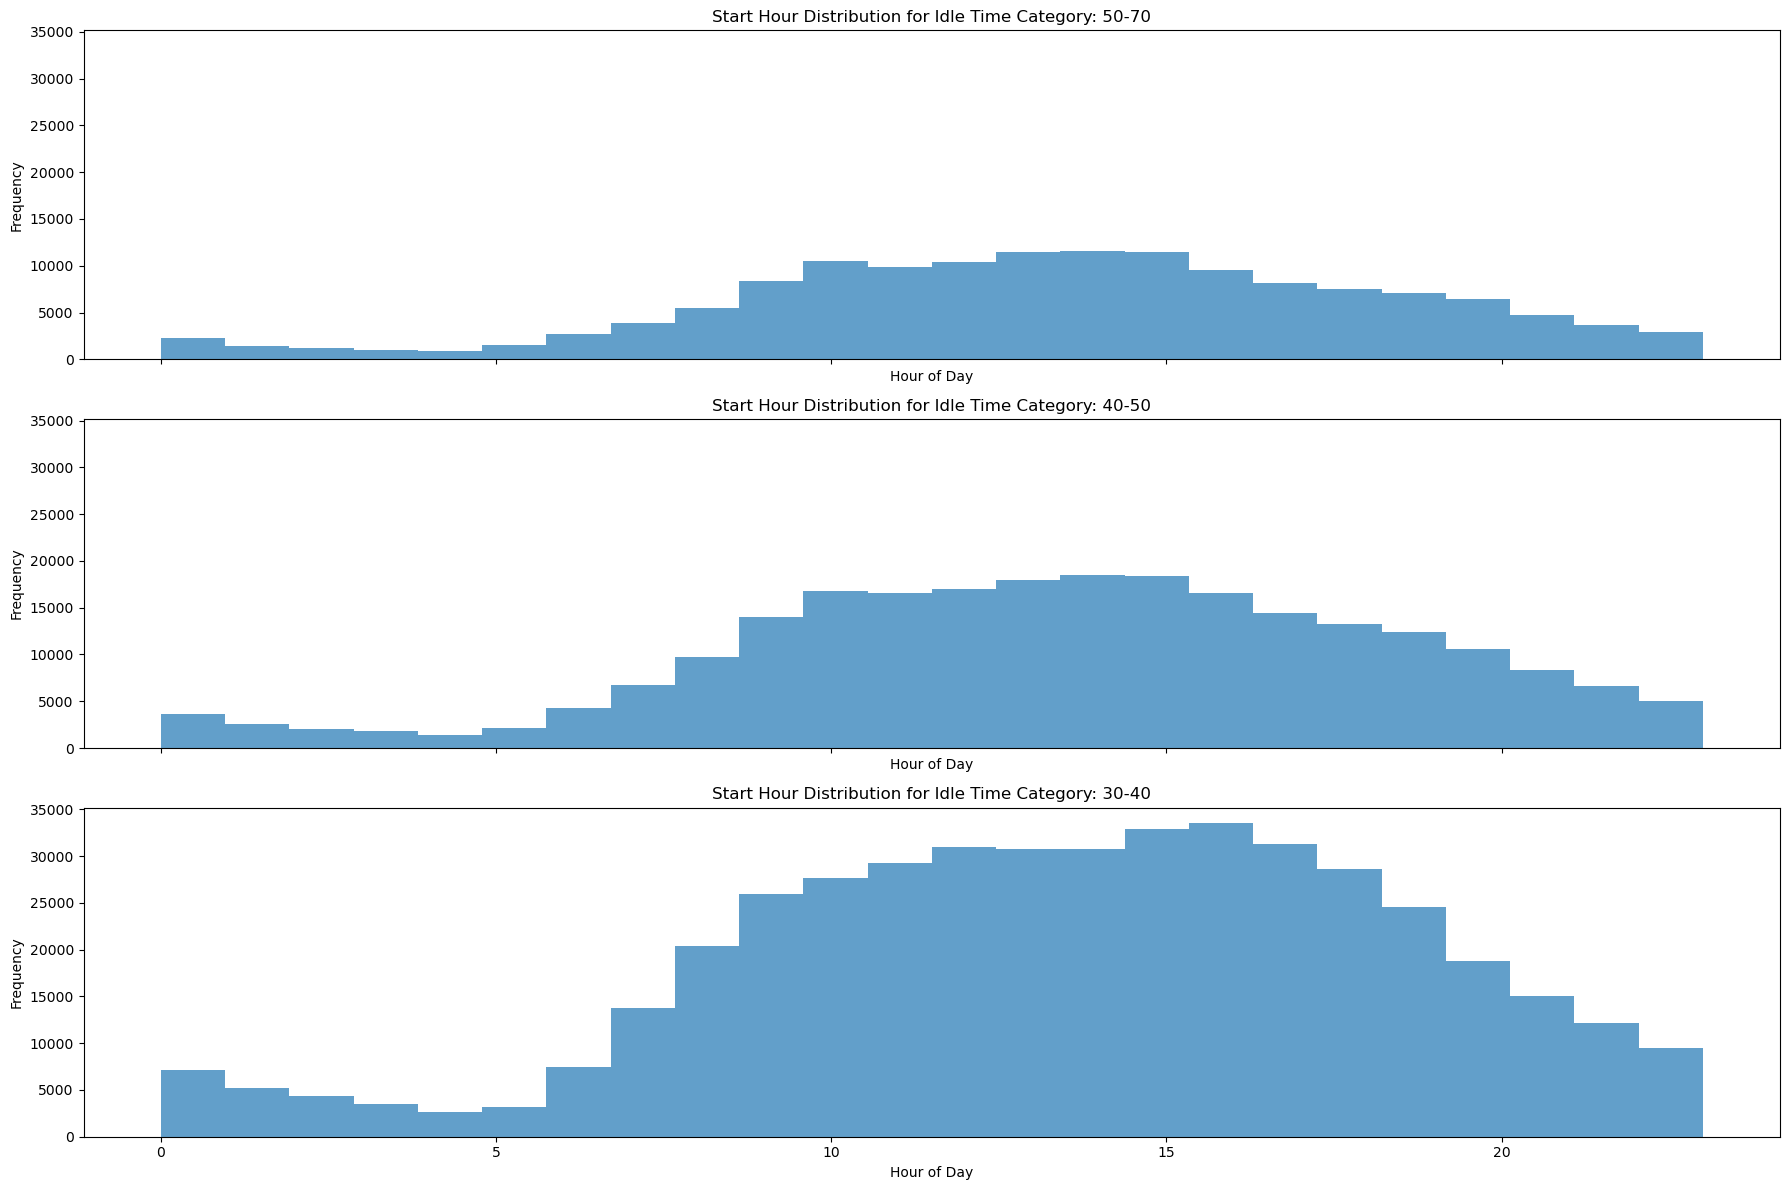

In [45]:
# Function to categorize idle times into ranges
def categorize_idle_time(idle_time):
    if 20 <= idle_time < 30:
        return '20-30'
    elif 30 <= idle_time < 40:
        return '30-40'
    elif 40 <= idle_time < 50:
        return '40-50'
    elif 50 <= idle_time < 70:
        return '50-70'
    else:
        return 'other'

# Categorize idle times
gdf_idle['idle_time_category'] = gdf_idle['idle_time'].apply(categorize_idle_time)

categories = [cat for cat in gdf_idle['idle_time_category'].unique() if cat != 'other']

num_categories = len(categories)
fig, axes = plt.subplots(num_categories, 1, figsize=(18, 4 * num_categories), sharex=True, sharey = True)

for ax, category in zip(axes, categories):
    data = gdf_idle[gdf_idle['idle_time_category'] == category]
    ax.hist(data['hour'], bins=24, alpha=0.7)
    ax.set_title(f'Start Hour Distribution for Idle Time Category: {category}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


There is no significant spike around lunch hours for any of the idle time categories, therefore we simply remove idle times larger than 75 minutes to ensure working period idle times.

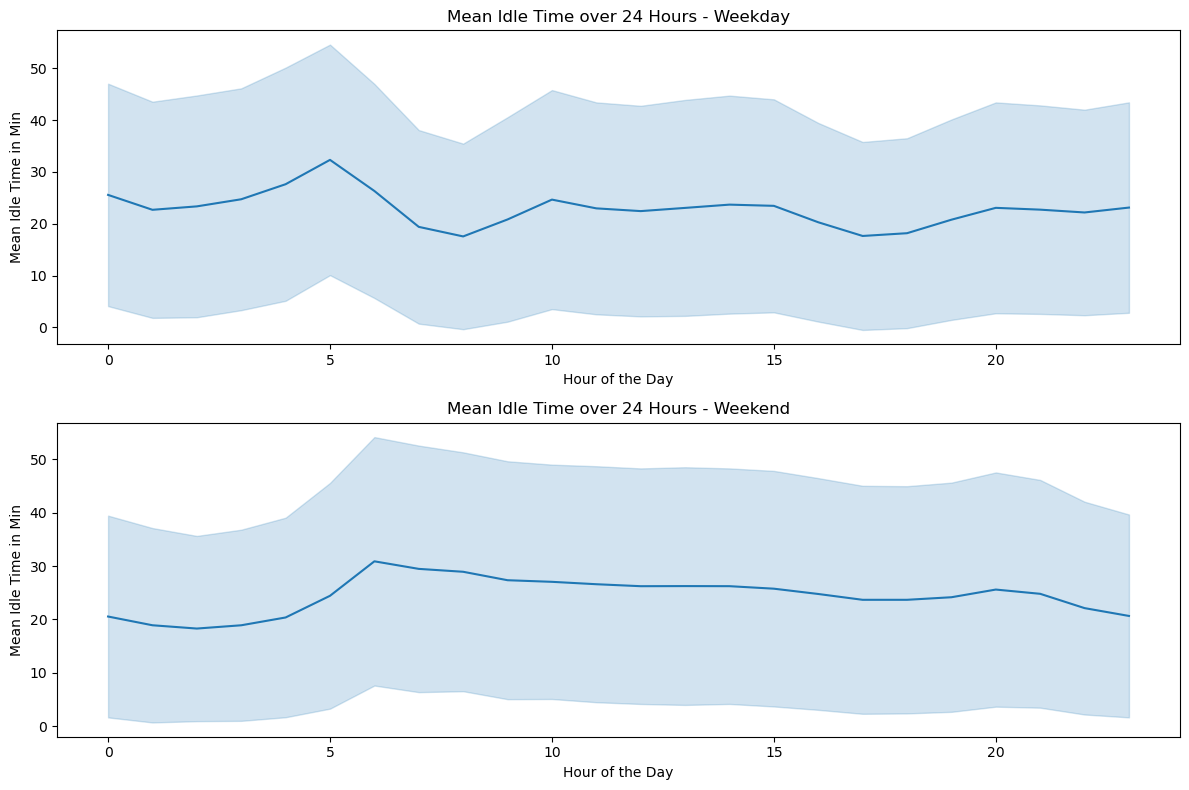

In [47]:
def lineplot_across_day(data, ylabel, title, ax_index):
    ax = axes[ax_index]
    sns.lineplot(x='hour', y='value', data=data, ax=ax, errorbar='sd')
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Hour of the Day')

gdf_idle_cleaned_weekday = gdf_idle[(gdf_idle['idle_time'] <= 75) & (gdf_idle['is_weekend'] == 0)][['day_of_year', 'hour', 'idle_time']]
gdf_idle_cleaned_weekday.columns = ['day_of_year', 'hour', 'value']

gdf_idle_cleaned_weekend = gdf_idle[(gdf_idle['idle_time'] <= 75) & (gdf_idle['is_weekend'] == 1)][['day_of_year', 'hour', 'idle_time']]
gdf_idle_cleaned_weekend.columns = ['day_of_year', 'hour', 'value']

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes = axes.flatten()

lineplot_across_day(gdf_idle_cleaned_weekday, 'Mean Idle Time in Min', 'Mean Idle Time over 24 Hours - Weekday', 0)
lineplot_across_day(gdf_idle_cleaned_weekend, 'Mean Idle Time in Min', 'Mean Idle Time over 24 Hours - Weekend', 1)
plt.tight_layout()

There are two plunges in the weekday plot at roughly 6-9 am and 4-6pm, which are typical rush hours. During these times many people might order taxis for commuting purposes, resulting in less idle times for the taxis. However, the plunges are rather small possibly due to less trafic since more people work from home because of covid.

# Spatial-Temporal Analytics

## Trip Pickup and Dropoff Frequency throughout the Day

In [51]:
gdf_idle['time_of_day'].unique()

array(['afternoon', 'evening', 'night', 'morning'], dtype=object)

C:\Users\ducan\AppData\Local\Temp\ipykernel_27800\1391972779.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trips_geo['centroid'] = trips_geo.geometry.centroid
C:\Users\ducan\AppData\Local\Temp\ipykernel_27800\1391972779.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.array(list(zip(trips_geo.centroid.x, trips_geo.centroid.y)))
C:\Users\ducan\AppData\Local\Temp\ipykernel_27800\1391972779.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trips_geo['centroid'] = trips_geo.geometry.centroid
C:\Users\ducan\AppData\Local\Temp\ipykernel_27800\13919

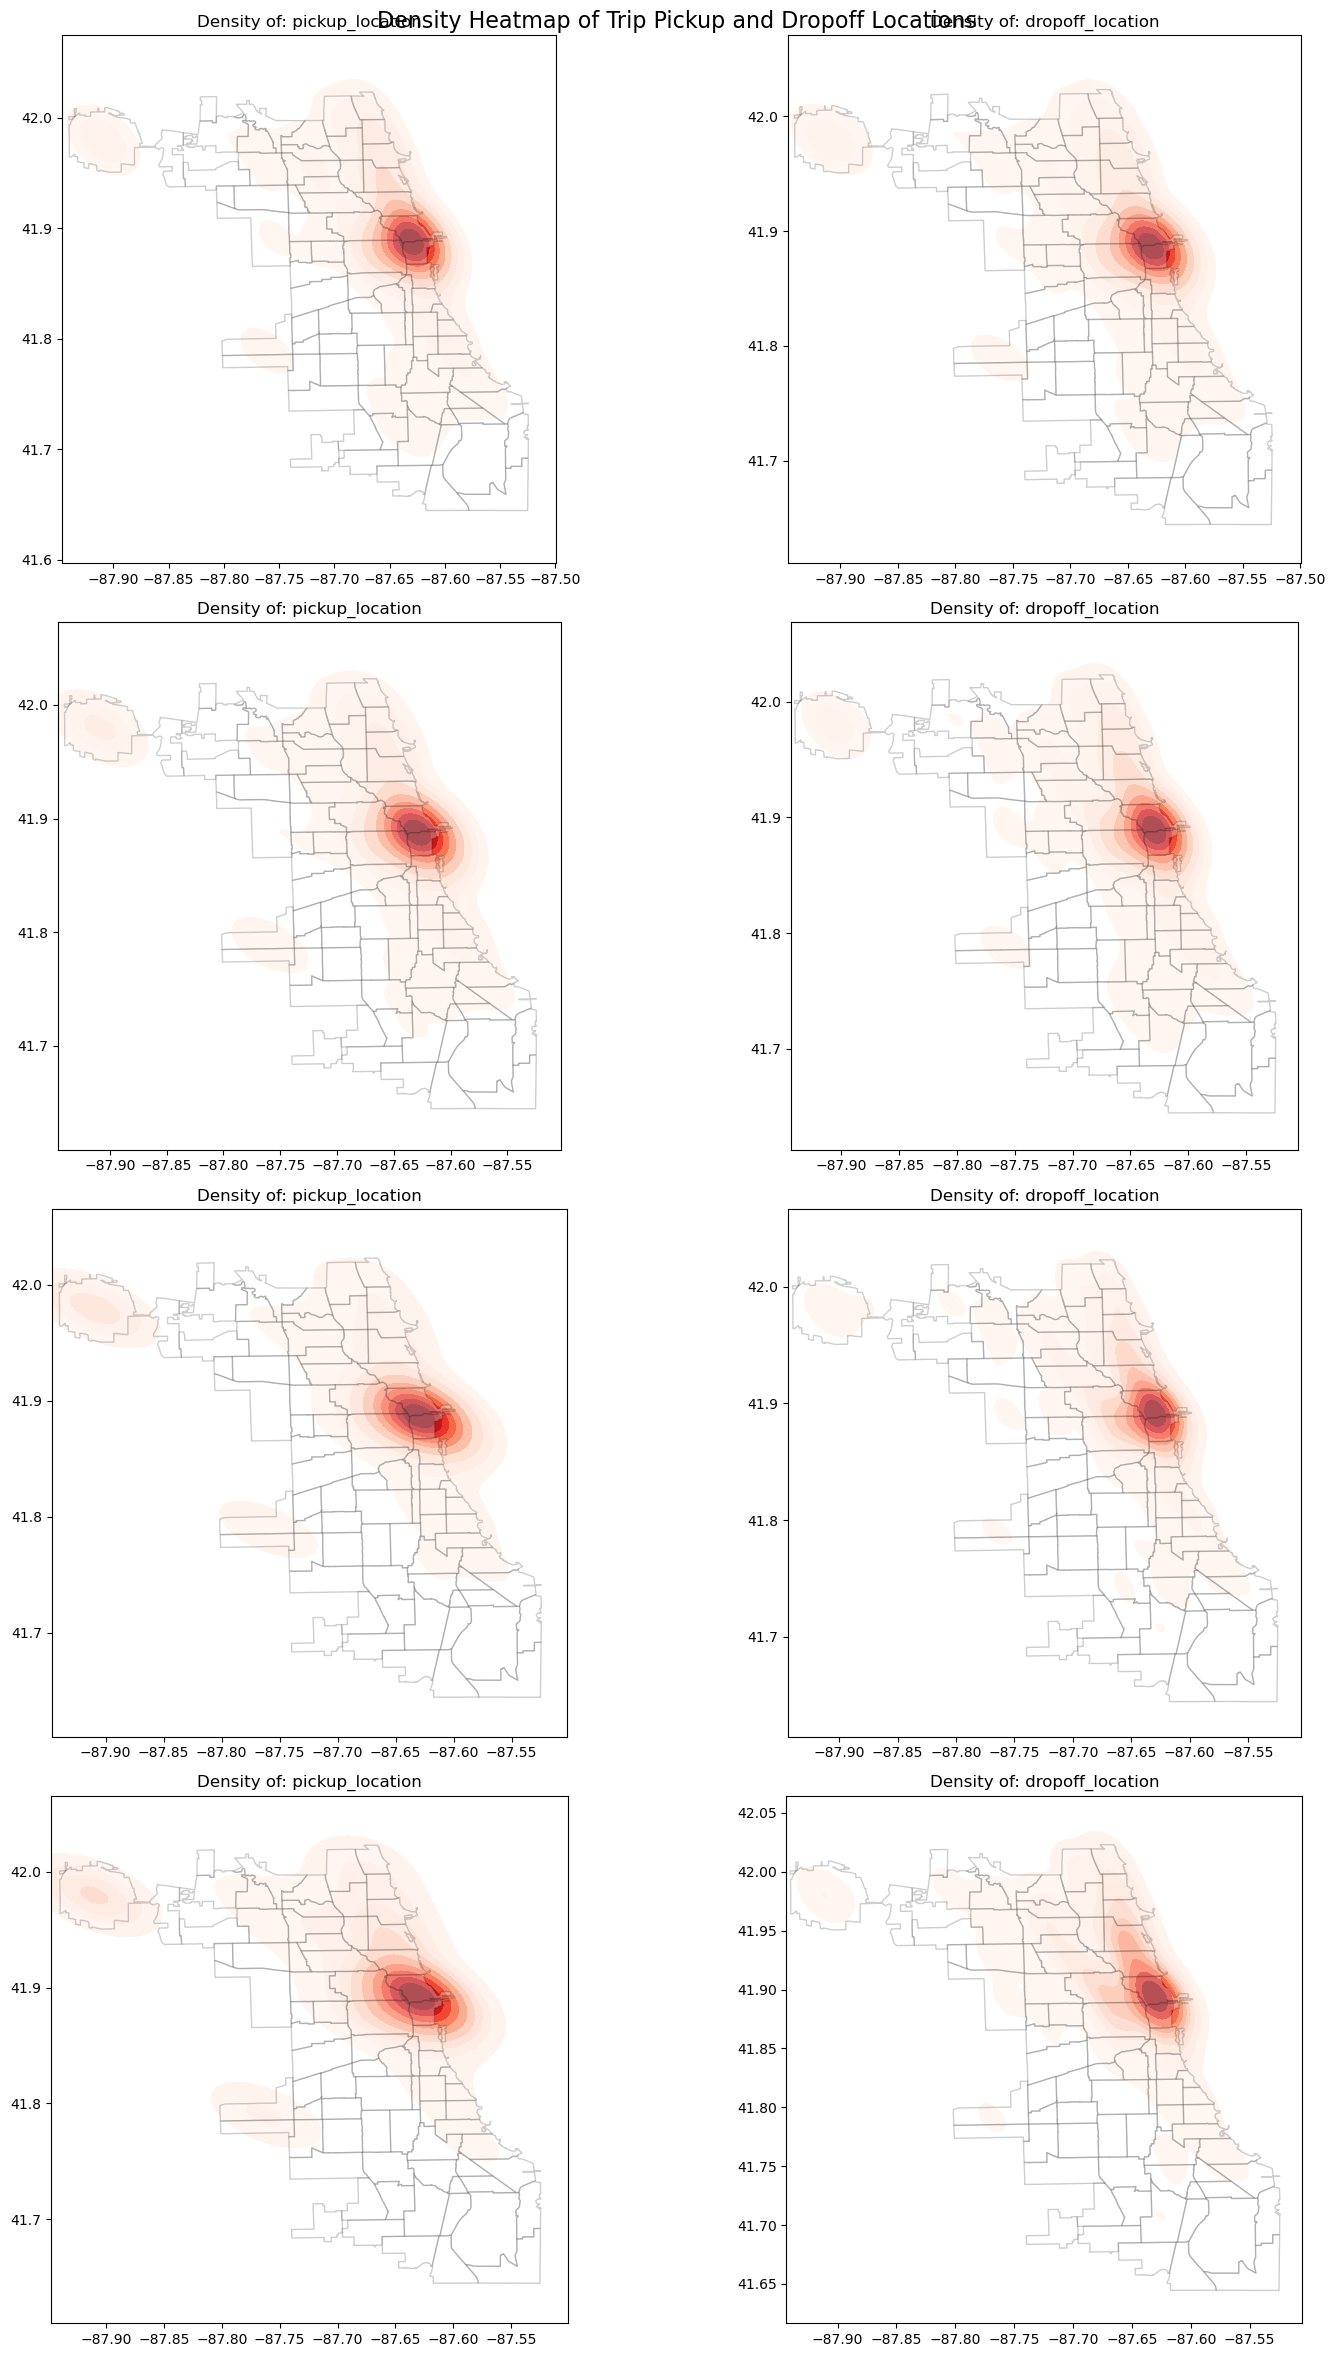

In [52]:
time_of_days = ['morning', 'afternoon', 'evening', 'night']

fig, ax = plt.subplots(4,2, figsize=(16,24))
ax = ax.flatten()

ax_index = 0
    
for time_of_day in time_of_days:
    density_heatmap(gdf_idle[gdf_idle['time_of_day'] == time_of_day], 'pickup_location', ax_index)
    density_heatmap(gdf_idle[gdf_idle['time_of_day'] == time_of_day], 'dropoff_location', ax_index+1)
    ax_index +=2

fig.suptitle('Density Heatmap of Trip Pickup and Dropoff Locations', fontsize=16)
plt.tight_layout()
plt.show()

### TODO - also use chloropleth to better differentiate

### TODO - check for weekend weekday differences

## Chloropleth Map of Average Trip Price, Length and Duration across various Time Buckets

C:\Users\ducan\AppData\Local\Temp\ipykernel_27800\177504133.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


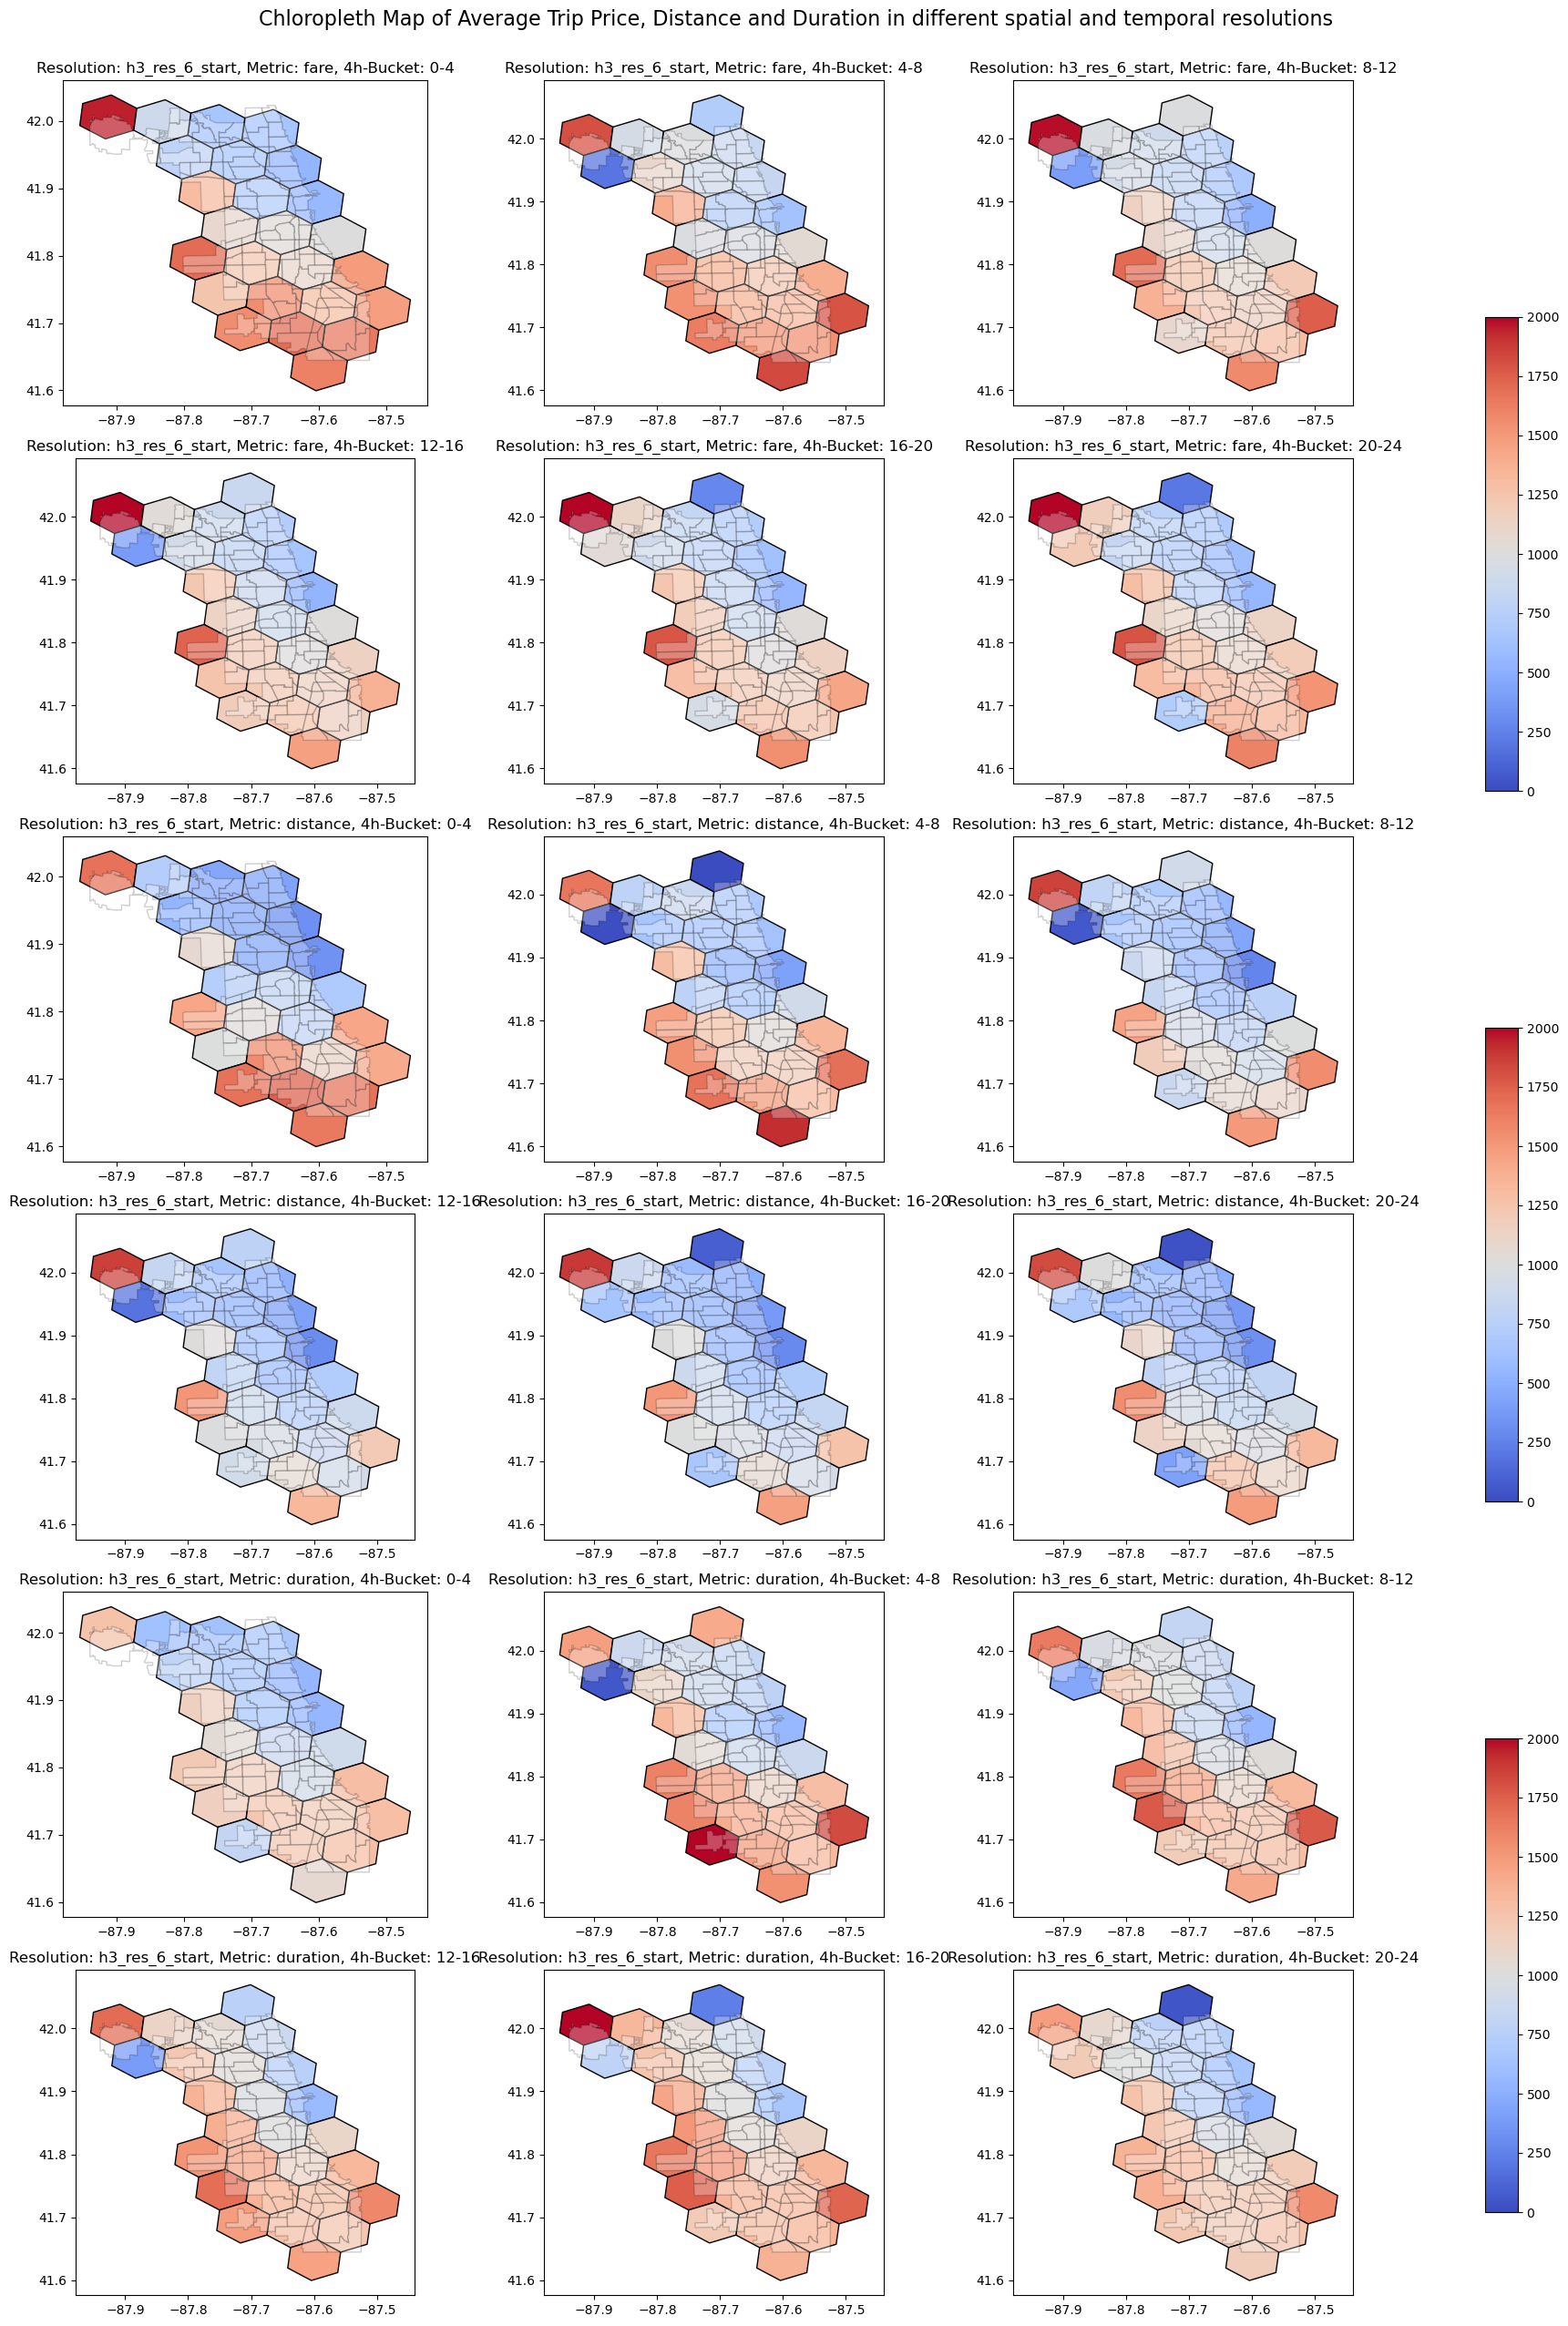

In [118]:
resolution = 'h3_res_6_start'
metrics = ['fare', 'distance', 'duration']
h_buckets = ['0-4', '4-8', '8-12', '12-16', '16-20', '20-24']

nrows = len(h_buckets)
ncols = len(metrics)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 4 + 2))
axes = axes.flatten()

ax_index = 0
metric_index = 0
max_values = [35, 20, 2000]


# To keep track of all the plots for colorbar
im = None

for metric in metrics:
    for h_bucket in h_buckets:
        ax = axes[ax_index]
        norm = mcolors.Normalize(vmin=0, vmax=max_values[metric_index])
        cmap = plt.cm.coolwarm
        im = chloropleth_means_map(gdf_idle[gdf_idle['4h_bucket'] == h_bucket], resolution, metric).plot(ax=ax, column='mean', cmap=cmap, norm=norm, edgecolor='k', legend=False)
        plot_chicago_shape(ax)
        ax.set_title(f'Resolution: {resolution}, Metric: {metric}, 4h-Bucket: {h_bucket}')
        ax_index += 1
    metric_index +=1

# Create colorbars for each group of 6 subplots
for i in range(3):
    cbar_ax = fig.add_axes([0.92, 0.65 - i * 0.3, 0.02, 0.2])
    fig.colorbar(im.collections[0], cax=cbar_ax, orientation='vertical', norm=norm, cmap=cmap)
    cbar_ax.set_label('Mean Value')

fig.suptitle('Chloropleth Map of Average Trip Price, Distance and Duration in different spatial and temporal resolutions', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(top=0.95)
plt.show()


## Chloropleth Map of Average Idle Time based on End Location

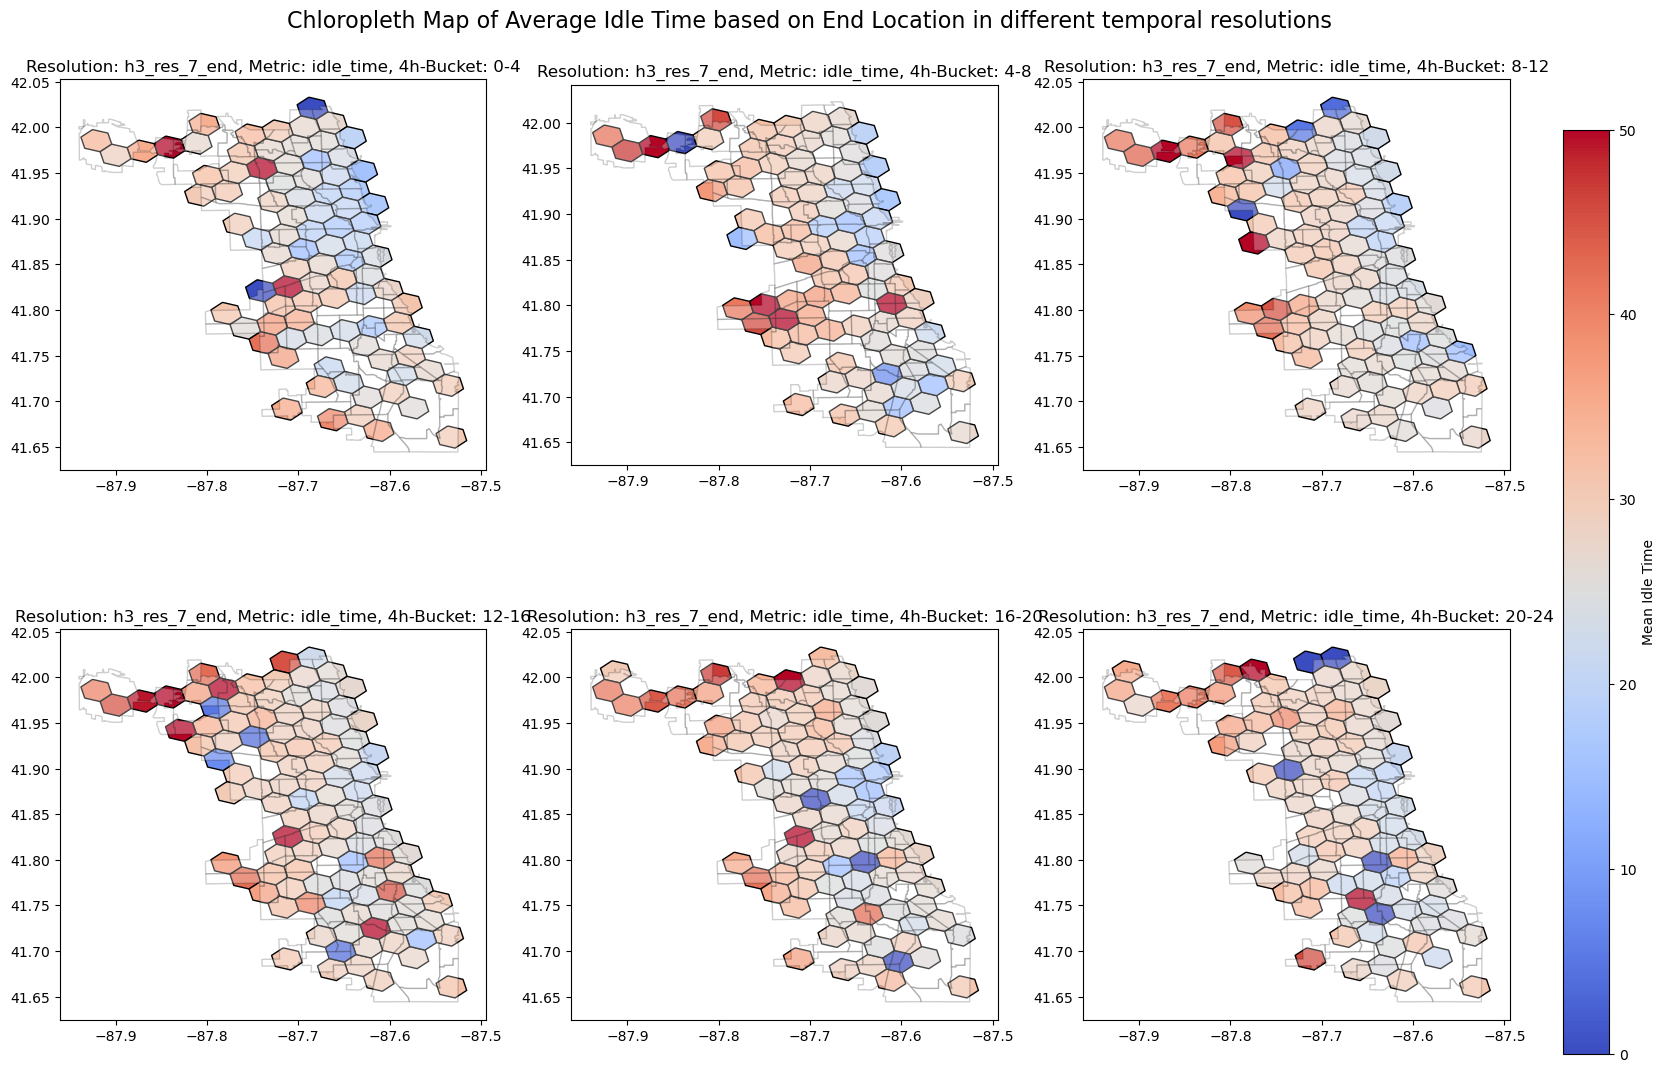

In [119]:
resolution = 'h3_res_7_end'
metrics = ['idle_time']
h_buckets = ['0-4', '4-8', '8-12', '12-16', '16-20', '20-24']

nrows = len(h_buckets)
ncols = len(metrics)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

ax_index = 0

norm = mcolors.Normalize(vmin=0, vmax=50)
cmap = matplotlib.colormaps['coolwarm']

# To keep track of all the plots for colorbar
im = None

for metric in metrics:
    for h_bucket in h_buckets:
        ax = axes[ax_index]
        im = chloropleth_means_map(gdf_idle[(gdf_idle['4h_bucket'] == h_bucket) & 
                                             (gdf_idle['idle_time'] <= 75) & 
                                             (gdf_idle['idle_time'] >= 0)], 
                                   resolution, metric).plot(ax=ax, 
                                                            column='mean', 
                                                            cmap=cmap, 
                                                            norm=norm, 
                                                            edgecolor='k', 
                                                            legend=False)
        plot_chicago_shape(ax)
        ax.set_title(f'Resolution: {resolution}, Metric: {metric}, 4h-Bucket: {h_bucket}')
        ax_index += 1

# Create a colorbar based on the last plot
cbar = fig.colorbar(im.collections[0], ax=axes, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('Mean Idle Time')

fig.suptitle('Chloropleth Map of Average Idle Time based on End Location in different temporal resolutions', fontsize=16)
plt.subplots_adjust(right=0.85)
plt.subplots_adjust(top=0.95)
plt.show()
